In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import time
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
# must be >=2.6.2
tf.__version__

'2.7.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Execution > Modifier le type d'execution > accelerateur materiel
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 29 02:33:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Execution > Modifier le type d'execution > Configuration de l'environement d'execution
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Set the parameters

In [ ]:
target_shape = (200,200)
batch_size = 2**9 # 2**9 is the max for colab pro with high ram
# batch_size = 8 # TODO: change the batch_size back to a large number

## Define the train input pipeline

In [ ]:
def get_object_location(row, image):
    id_, x, y, w, h = row
    image_height,image_width = image.shape[0],image.shape[1]
    id_ = int(id_)
    x = int(max(x,0))
    y = int(max(y,0))
    w = int(min(w,image_width-x))
    h = int(min(h,image_height-y))
    obj = image[y:y+h,x:x+w]
    obj = cv2.resize(obj, dsize=target_shape)#, interpolation=cv2.INTER_CUBIC) #TODO : should I keep this interpolation?
    obj = obj.astype(np.float32)
    obj /= 255.
    return obj,np.array([x/image_width,y/image_height,w/image_width,h/image_height])

def triplet_gen(mode):
    # gt file header
    header = {"frame":0, "id":1, "x":2, "y":3, "w":4, "h":5, "x1":6, "x2":7, "conf":9}

    # get the list of gt files
    gt_files = sorted(glob.glob("drive/MyDrive/cs230-data/train/*/*/gt.txt"))
    if mode == "train":
        gt_files = gt_files[:-5] #TODO: should be -1
    elif mode == "val":
        gt_files = gt_files[-1:]
    else:
        raise RuntimeError("Invalid mode. It must be either 'train' or 'val'.")

    def gen():
        for gt_file in gt_files:
            gt = np.loadtxt(gt_file,delimiter=",")
            frames = np.unique(gt[:,header["frame"]])
            dir_path = os.sep.join(gt_file.split(os.sep)[:-2])
            old_image_file = os.path.join(dir_path,"img1/{:06d}.jpg".format(int(frames[0])))
            old_image = cv2.imread(old_image_file)
            old_image = cv2.cvtColor(old_image, cv2.COLOR_BGR2RGB)
            old_gt_frame = gt[gt[:,header["frame"]] == frames[0]]
            for frame in frames[1:]:
                new_image_file = os.path.join(dir_path,"img1/{:06d}.jpg".format(int(frame)))
                new_image = cv2.imread(new_image_file)
                new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
                new_gt_frame = gt[gt[:,header["frame"]] == frame]
                for row in old_gt_frame:
                    # get anchor object from the old image and gt
                    anchor = get_object_location(row[1:6], old_image)
                    # find the positive in the new image and gt
                    positive_row = new_gt_frame[new_gt_frame[:,header["id"]] == row[header["id"]]]
                    if len(positive_row) == 0: # if this object is not in the next frame, then cannot form triplet
                      continue
                    positive_row = positive_row[0]
                    positive = get_object_location(positive_row[1:6],new_image)
                    # find the negative in the new image and gt
                    negative_row = new_gt_frame[new_gt_frame[:,header["id"]] != row[header["id"]]]
                    if len(negative_row) == 0: # if the next frame has no other objects, then cannot form triplet
                      continue
                    negative_row = negative_row[random.randint(0, len(negative_row)-1)]
                    negative = get_object_location(negative_row[1:6],new_image)
   
                    yield anchor,positive,negative
                # update the iterating variables
                old_image = new_image  
                old_gt_frame = new_gt_frame
    return gen


train_dataset = tf.data.Dataset.from_generator(triplet_gen("train"), ((tf.float32,tf.float32),(tf.float32,tf.float32),(tf.float32,tf.float32)), ((target_shape + (3,),(4,)),(target_shape + (3,),(4,)),(target_shape + (3,),(4,))))
# train_dataset = train_dataset.shuffle(buffer_size=2^14)
train_dataset = train_dataset.batch(batch_size, drop_remainder=False).repeat() #TODO: should set to False?
# train_dataset = train_dataset.prefetch(8)

val_dataset = tf.data.Dataset.from_generator(triplet_gen("val"), ((tf.float32,tf.float32),(tf.float32,tf.float32),(tf.float32,tf.float32)), ((target_shape + (3,),(4,)),(target_shape + (3,),(4,)),(target_shape + (3,),(4,))))
# val_dataset = val_dataset.shuffle(buffer_size=2^14)
val_dataset = val_dataset.batch(batch_size, drop_remainder=False).repeat() #TODO: should set to False?
# val_dataset = val_dataset.prefetch(8)

In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 30))

    axs = fig.subplots(8, 3)
    for i in range(8):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

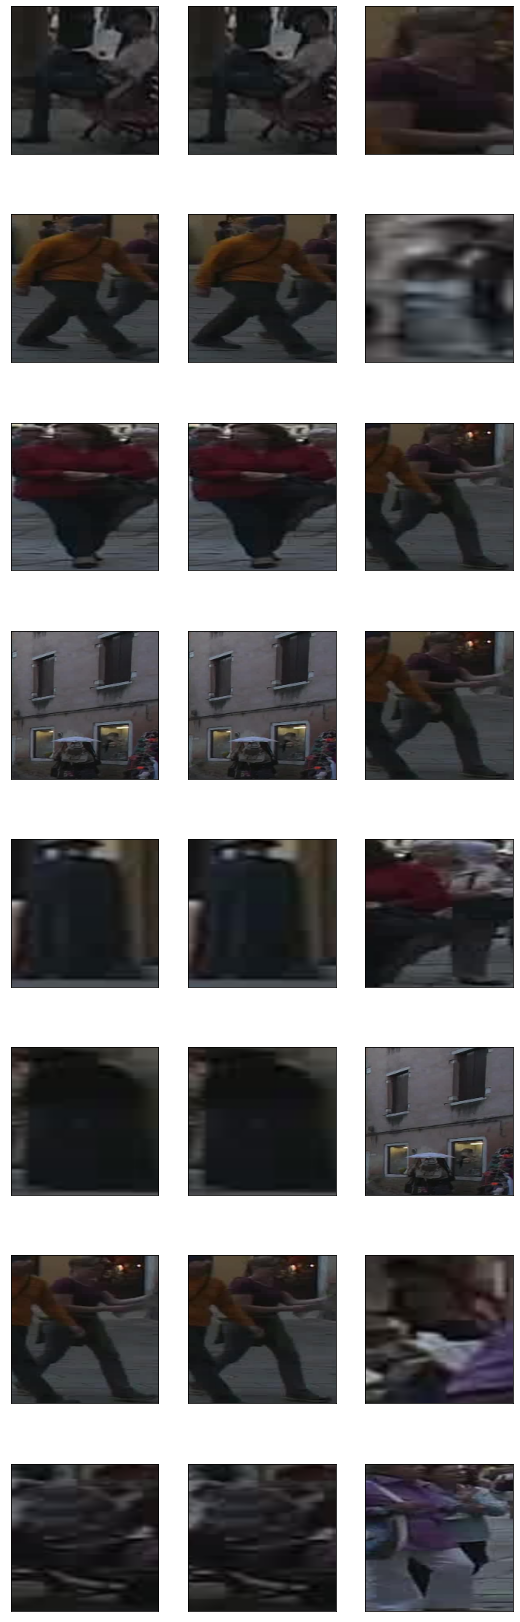

In [ ]:
sample = next(iter(train_dataset))
visualize(sample[0][0],sample[1][0],sample[2][0])

## Define the siamese model
source: https://keras.io/examples/vision/siamese_network/

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet



class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, embedding, margin=0.5):
        super(SiameseModel, self).__init__()
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

        # the embedding model
        if embedding is None:
          base_cnn = resnet.ResNet50(
              weights="imagenet", input_shape=target_shape + (3,), include_top=False
          )
          location_input = layers.Input(shape=(4,))

          flatten = layers.Flatten()(base_cnn.output)
          dense1 = layers.Dense(256, activation="relu")(flatten) # TODO: made it simpler by going from 512 to 256
          dense1 = layers.BatchNormalization()(dense1)
          concat = layers.Concatenate()([dense1, location_input])
          dense2 = layers.Dense(128, activation="relu")(concat) # TODO: made it simpler by going from 256 to 128
          dense2 = layers.BatchNormalization()(dense2)
          output = layers.Dense(128)(dense2)# TODO: made it simpler by going from 256 to 128

          # train only the last layers of the resnet (when set to conv5_block3_out,
          # none is trainable)
          trainable = False
          for layer in base_cnn.layers:
              if layer.name == "conv5_block3_out": 
                  trainable = True
              layer.trainable = trainable

          self.embedding = Model([base_cnn.input,location_input], output, name="Embedding")
        else: # if embedding is passed as arg
          self.embedding = embedding

        # the siamese network model 
        anchor_input_image = layers.Input(name="anchor_image", shape=target_shape + (3,))
        positive_input_image = layers.Input(name="positive_image", shape=target_shape + (3,))
        negative_input_image = layers.Input(name="negative_image", shape=target_shape + (3,))

        anchor_input_location = layers.Input(name="anchor_location",shape=(4,))
        positive_input_location = layers.Input(name="positive_location",shape=(4,))
        negative_input_location = layers.Input(name="negative_location",shape=(4,))

        distances = DistanceLayer()(
            self.embedding((resnet.preprocess_input(anchor_input_image), anchor_input_location)),
            self.embedding((resnet.preprocess_input(positive_input_image), positive_input_location)),
            self.embedding((resnet.preprocess_input(negative_input_image), negative_input_location)),
        )

        siamese_network = Model(
            inputs=[(anchor_input_image,   anchor_input_location),
                    (positive_input_image, positive_input_location), 
                    (negative_input_image, negative_input_location)],
            outputs=distances
        )
        self.siamese_network = siamese_network

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

    def save_embedding(self, path):
      self.embedding.save(path)


In [ ]:
# Source: https://www.tensorflow.org/guide/keras/custom_callback

class StatusCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))


class LossPrintingCallback(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        print(
            "Up to batch {}, the average loss is {:7.10f}.".format(batch, logs["loss"])
        )

    def on_test_batch_end(self, batch, logs=None):
        print(
            "Up to batch {}, the average loss is {:7.10f}.".format(batch, logs["loss"])
        )

    def on_epoch_end(self, epoch, logs=None):
        print(
            "The average train loss for epoch {} is {:7.10f}".format(
                epoch, logs["loss"]
            ),
            "\nThe average val loss for epoch {} is {:7.10f}".format(
                epoch, logs["val_loss"]
            )
        )

# to save embedding models
class SaveEmbeddingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        path = "drive/MyDrive/cs230-models/training_2/models_epoch_{}_trainloss_{}_valloss_{}".format(epoch,logs["loss"],logs["val_loss"])
        print("Saving embedding model at {}".format(path))
        self.model.save_embedding(path)

       


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

# source: https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        duration = time.time() - self.epoch_time_start
        print("Epoch {} took {} seconds to run.".format(epoch,duration))
        self.times.append(duration)


## Train the siamese model

In [ ]:
siamese_model = SiameseModel(embedding = None) # pass in the embedding if you have one already trained
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
# callbacks
time_callback = TimeHistory()
reduce_lr = ReduceLROnPlateau(
                  monitor="loss",
                  factor=0.1,  # TODO: change that to 0.5 because I believe that training_1 had too steep drop in lr
                  patience=2   # TODO: change that to 4 because 2 epochs don't even go over all the data
              )

history = siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset, verbose = 0, steps_per_epoch=100, validation_steps = 100, use_multiprocessing=True, workers = 8,
                  callbacks=[StatusCallback(), LossPrintingCallback(), SaveEmbeddingCallback(), time_callback, reduce_lr]) 
# TODO: should add lr scheduler to CustomLearningRateScheduler(lr_schedule)
# TODO: use ReduceLROnPlateuau() instead of my custom approach


Starting training; got log keys: []
Start epoch 0 of training; got log keys: []
Up to batch 0, the average loss is 0.3080402017.
Up to batch 1, the average loss is 0.2808881402.
Up to batch 2, the average loss is 0.2651096880.
Up to batch 3, the average loss is 0.2392356098.
Up to batch 4, the average loss is 0.2148537338.
Up to batch 5, the average loss is 0.1950422078.
Up to batch 6, the average loss is 0.1786890030.
Up to batch 7, the average loss is 0.1656068116.
Up to batch 8, the average loss is 0.1540147811.
Up to batch 9, the average loss is 0.1436538249.
Up to batch 10, the average loss is 0.1333819181.
Up to batch 11, the average loss is 0.1242944822.
Up to batch 12, the average loss is 0.1164558828.
Up to batch 13, the average loss is 0.1099869236.
Up to batch 14, the average loss is 0.1046432331.
Up to batch 15, the average loss is 0.1003742218.
Up to batch 16, the average loss is 0.0968869478.
Up to batch 17, the average loss is 0.0924301445.
Up to batch 18, the average lo

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 0 took 1241.9281356334686 seconds to run.
Start epoch 1 of training; got log keys: []
Up to batch 0, the average loss is 0.0029172804.
Up to batch 1, the average loss is 0.0020587153.
Up to batch 2, the average loss is 0.0017371663.
Up to batch 3, the average loss is 0.0017647166.
Up to batch 4, the average loss is 0.0018101188.
Up to batch 5, the average loss is 0.0017951042.
Up to batch 6, the average loss is 0.0018604018.
Up to batch 7, the average loss is 0.0021079290.
Up to batch 8, the average loss is 0.0021133793.
Up to batch 9, the average loss is 0.0022238318.
Up to batch 10, the average loss is 0.0021733877.
Up to batch 11, the average loss is 0.0021026579.
Up to batch 12, the average loss is 0.0022263224.
Up to batch 13, the average loss is 0.0022252416.
Up to batch 14, the average loss is 0.0021186313.
Up to batch 15, the average loss is 0.0021166326.
Up to batch 16, the average loss is 0.0022461258.
Up to batch 17, the average loss is 0.0022148925.
Up to batch 18, th

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 1 took 810.29674077034 seconds to run.
Start epoch 2 of training; got log keys: []
Up to batch 0, the average loss is 0.0014369288.
Up to batch 1, the average loss is 0.0025139200.
Up to batch 2, the average loss is 0.0020474987.
Up to batch 3, the average loss is 0.0015356240.
Up to batch 4, the average loss is 0.0012863122.
Up to batch 5, the average loss is 0.0011299705.
Up to batch 6, the average loss is 0.0009953707.
Up to batch 7, the average loss is 0.0020222377.
Up to batch 8, the average loss is 0.0018459503.
Up to batch 9, the average loss is 0.0017061116.
Up to batch 10, the average loss is 0.0016270760.
Up to batch 11, the average loss is 0.0014914862.
Up to batch 12, the average loss is 0.0014765763.
Up to batch 13, the average loss is 0.0013711065.
Up to batch 14, the average loss is 0.0012940946.
Up to batch 15, the average loss is 0.0016615572.
Up to batch 16, the average loss is 0.0016203317.
Up to batch 17, the average loss is 0.0015997359.
Up to batch 18, the a

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2 took 802.0336339473724 seconds to run.
Start epoch 3 of training; got log keys: []
Up to batch 0, the average loss is 0.0002226188.
Up to batch 1, the average loss is 0.0008896067.
Up to batch 2, the average loss is 0.0018725883.
Up to batch 3, the average loss is 0.0057453457.
Up to batch 4, the average loss is 0.0073289634.
Up to batch 5, the average loss is 0.0083193844.
Up to batch 6, the average loss is 0.0130980453.
Up to batch 7, the average loss is 0.0127824564.
Up to batch 8, the average loss is 0.0136413593.
Up to batch 9, the average loss is 0.0165886097.
Up to batch 10, the average loss is 0.0269996412.
Up to batch 11, the average loss is 0.0390399247.
Up to batch 12, the average loss is 0.0389545411.
Up to batch 13, the average loss is 0.0367433541.
Up to batch 14, the average loss is 0.0348212831.
Up to batch 15, the average loss is 0.0327767543.
Up to batch 16, the average loss is 0.0309747849.
Up to batch 17, the average loss is 0.0295437835.
Up to batch 18, the

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 3 took 749.3426601886749 seconds to run.
Start epoch 4 of training; got log keys: []
Up to batch 0, the average loss is 0.0008093256.
Up to batch 1, the average loss is 0.0006958750.
Up to batch 2, the average loss is 0.0007590486.
Up to batch 3, the average loss is 0.0008647607.
Up to batch 4, the average loss is 0.0008392292.
Up to batch 5, the average loss is 0.0008740157.
Up to batch 6, the average loss is 0.0009898075.
Up to batch 7, the average loss is 0.0008830382.
Up to batch 8, the average loss is 0.0008774453.
Up to batch 9, the average loss is 0.0007897008.
Up to batch 10, the average loss is 0.0007277759.
Up to batch 11, the average loss is 0.0006671278.
Up to batch 12, the average loss is 0.0006548061.
Up to batch 13, the average loss is 0.0006830353.
Up to batch 14, the average loss is 0.0006622675.
Up to batch 15, the average loss is 0.0006986113.
Up to batch 16, the average loss is 0.0007853271.
Up to batch 17, the average loss is 0.0007656566.
Up to batch 18, the

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 4 took 742.5273430347443 seconds to run.
Start epoch 5 of training; got log keys: []
Up to batch 0, the average loss is 0.0015579420.
Up to batch 1, the average loss is 0.0015550876.
Up to batch 2, the average loss is 0.0011882622.
Up to batch 3, the average loss is 0.0009009099.
Up to batch 4, the average loss is 0.0007786281.
Up to batch 5, the average loss is 0.0006791728.
Up to batch 6, the average loss is 0.0006206023.
Up to batch 7, the average loss is 0.0008122426.
Up to batch 8, the average loss is 0.0008758412.
Up to batch 9, the average loss is 0.0008067897.
Up to batch 10, the average loss is 0.0008044877.
Up to batch 11, the average loss is 0.0007374471.
Up to batch 12, the average loss is 0.0006876067.
Up to batch 13, the average loss is 0.0006384919.
Up to batch 14, the average loss is 0.0006272429.
Up to batch 15, the average loss is 0.0006187352.
Up to batch 16, the average loss is 0.0005926723.
Up to batch 17, the average loss is 0.0005597461.
Up to batch 18, the

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 5 took 748.9527509212494 seconds to run.
Start epoch 6 of training; got log keys: []
Up to batch 0, the average loss is 0.0008659221.
Up to batch 1, the average loss is 0.0004353845.
Up to batch 2, the average loss is 0.0004115250.
Up to batch 3, the average loss is 0.0006613444.
Up to batch 4, the average loss is 0.0006823389.
Up to batch 5, the average loss is 0.0010147871.
Up to batch 6, the average loss is 0.0008797034.
Up to batch 7, the average loss is 0.0007794134.
Up to batch 8, the average loss is 0.0007594661.
Up to batch 9, the average loss is 0.0006987897.
Up to batch 10, the average loss is 0.0006352633.
Up to batch 11, the average loss is 0.0006092343.
Up to batch 12, the average loss is 0.0005803792.
Up to batch 13, the average loss is 0.0005556115.
Up to batch 14, the average loss is 0.0005868973.
Up to batch 15, the average loss is 0.0005502162.
Up to batch 16, the average loss is 0.0005296931.
Up to batch 17, the average loss is 0.0005276706.
Up to batch 18, the

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 6 took 740.563768863678 seconds to run.
Start epoch 7 of training; got log keys: []
Up to batch 0, the average loss is 0.0003616789.
Up to batch 1, the average loss is 0.0005946595.
Up to batch 2, the average loss is 0.0005132440.
Up to batch 3, the average loss is 0.0006298512.
Up to batch 4, the average loss is 0.0006457170.
Up to batch 5, the average loss is 0.0006481960.
Up to batch 6, the average loss is 0.0006968106.
Up to batch 7, the average loss is 0.0006576043.
Up to batch 8, the average loss is 0.0007232869.
Up to batch 9, the average loss is 0.0007042683.
Up to batch 10, the average loss is 0.0006604783.
Up to batch 11, the average loss is 0.0006054384.
Up to batch 12, the average loss is 0.0006183305.
Up to batch 13, the average loss is 0.0005759775.
Up to batch 14, the average loss is 0.0005859162.
Up to batch 15, the average loss is 0.0005729914.
Up to batch 16, the average loss is 0.0005392861.
Up to batch 17, the average loss is 0.0005246515.
Up to batch 18, the 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 7 took 738.8283865451813 seconds to run.
Start epoch 8 of training; got log keys: []
Up to batch 0, the average loss is 0.0003436749.
Up to batch 1, the average loss is 0.0011089300.
Up to batch 2, the average loss is 0.0011063874.
Up to batch 3, the average loss is 0.0010084956.
Up to batch 4, the average loss is 0.0014016572.
Up to batch 5, the average loss is 0.0012286907.
Up to batch 6, the average loss is 0.0012647142.
Up to batch 7, the average loss is 0.0011998831.
Up to batch 8, the average loss is 0.0014686022.
Up to batch 9, the average loss is 0.0014091891.
Up to batch 10, the average loss is 0.0013785233.
Up to batch 11, the average loss is 0.0016831903.
Up to batch 12, the average loss is 0.0018975066.
Up to batch 13, the average loss is 0.0022529003.
Up to batch 14, the average loss is 0.0023573583.
Up to batch 15, the average loss is 0.0025056133.
Up to batch 16, the average loss is 0.0024256664.
Up to batch 17, the average loss is 0.0025225435.
Up to batch 18, the

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 8 took 748.5264632701874 seconds to run.
Start epoch 9 of training; got log keys: []
Up to batch 0, the average loss is 0.0002534490.
Up to batch 1, the average loss is 0.0006058638.
Up to batch 2, the average loss is 0.0004360856.
Up to batch 3, the average loss is 0.0004091037.
Up to batch 4, the average loss is 0.0003840146.
Up to batch 5, the average loss is 0.0004382569.
Up to batch 6, the average loss is 0.0004088781.
Up to batch 7, the average loss is 0.0003577683.
Up to batch 8, the average loss is 0.0003424417.
Up to batch 9, the average loss is 0.0003437118.
Up to batch 10, the average loss is 0.0003468479.
Up to batch 11, the average loss is 0.0003452934.
Up to batch 12, the average loss is 0.0003710875.
Up to batch 13, the average loss is 0.0003445813.
Up to batch 14, the average loss is 0.0003541918.
Up to batch 15, the average loss is 0.0004375626.
Up to batch 16, the average loss is 0.0004152060.
Up to batch 17, the average loss is 0.0004297629.
Up to batch 18, the

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 9 took 739.4874789714813 seconds to run.
Stop training; got log keys: ['loss', 'val_loss']


# Visualize the embedding and the siamese network architectures and plot the training and validation losses.

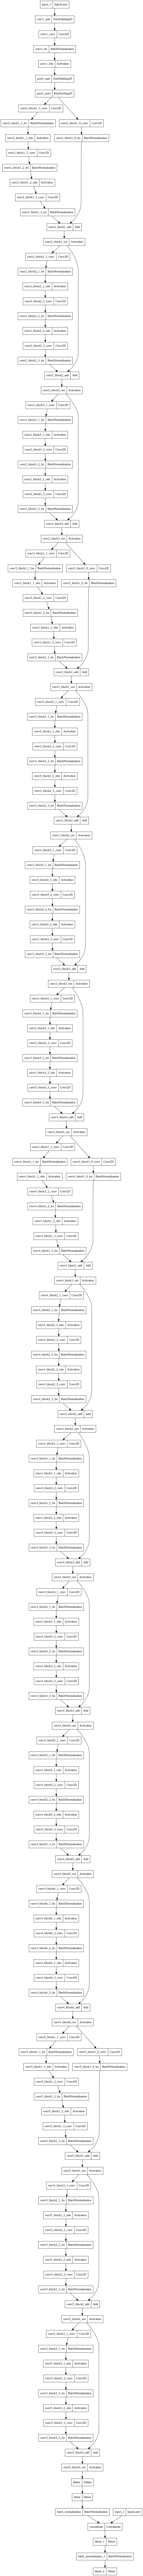

In [ ]:
tf.keras.utils.plot_model(siamese_model.embedding, to_file='drive/MyDrive/cs230-figures/embedding.png')

In [ ]:
tf.keras.Model.summary(siamese_model.embedding)

Model: "Embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

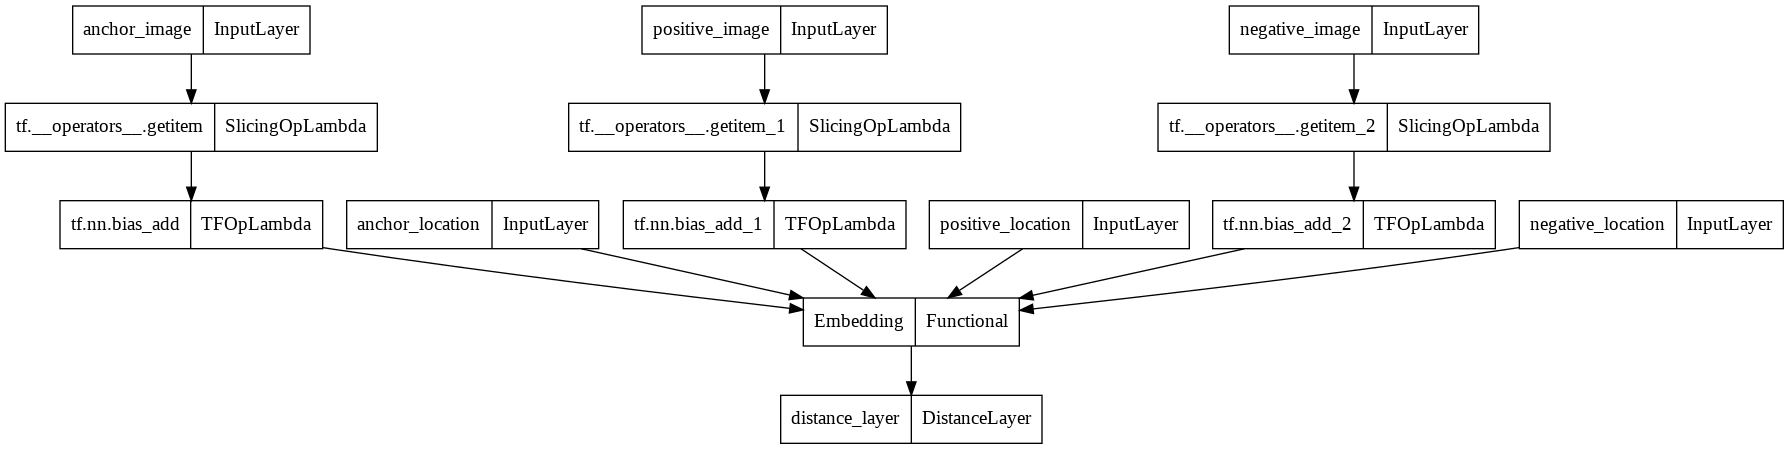

In [ ]:
tf.keras.utils.plot_model(siamese_model.siamese_network, to_file='drive/MyDrive/cs230-figures/siamese_network.png')

In [ ]:
tf.keras.Model.summary(siamese_model.siamese_network)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_image (InputLayer)      [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive_image (InputLayer)    [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative_image (InputLayer)    [(None, 200, 200, 3  0           []                               
                                )]                                                            

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'val_loss', 'lr'])


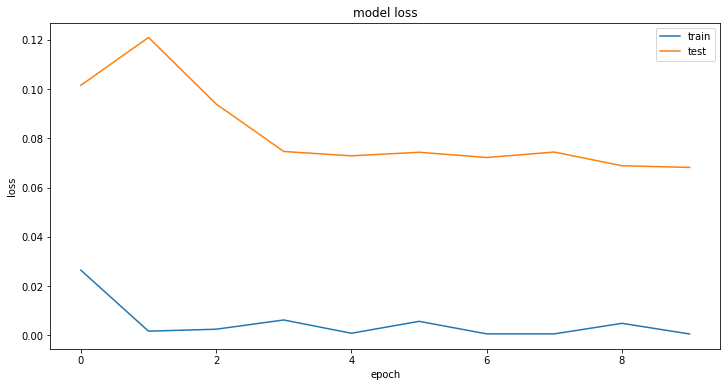

In [ ]:
# plot the train and val losses
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig("drive/MyDrive/cs230-figures/train_val_losses.png")
plt.show()   

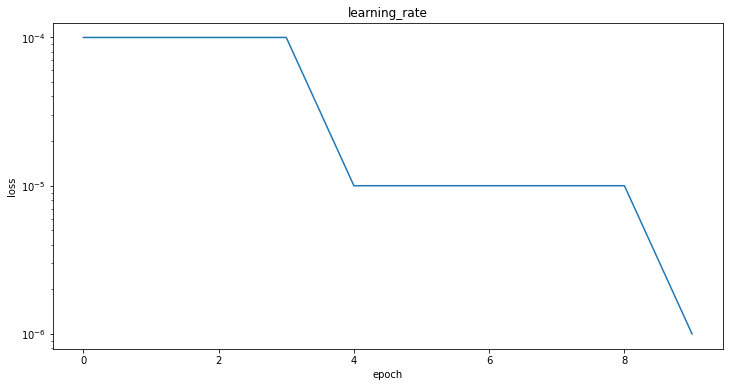

In [ ]:
# plot the learning rate
plt.figure(figsize=(12,6))
plt.semilogy(history.history['lr'])
plt.title('learning_rate')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig("drive/MyDrive/cs230-figures/training_lr.png")
plt.show()   

In [ ]:
# the lines to save  siamese network
# siamese_model.save_embedding("drive/MyDrive/cs230-models/model_1")

INFO:tensorflow:Assets written to: drive/MyDrive/cs230-models/model_1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
